<a href="https://colab.research.google.com/github/Prabhiraj-P/GANime-Generator/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
import os

In [3]:
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

100%|██████████| 395M/395M [00:03<00:00, 107MB/s]


In [4]:
DATA_DIR='./animefacedataset'

In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [6]:
image_size=64
batch_size=64
stats=(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [7]:
train_ds=ImageFolder(DATA_DIR,
                     transform = T.Compose([T.Resize(image_size),
                                            T.CenterCrop(image_size),
                                            T.ToTensor(),
                                            T.Normalize(*stats)])
                     )

In [8]:
train_dl=DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=False ); #num_workers=3 pin_memory=True

In [9]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# denormalizing normalised image to visualise it on maptplotlib imshow
def denorm(img_tensor):
  return img_tensor*stats[1][0]+stats[0][0]

In [11]:
def show_image(images, nmax=64):


  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])

  ax.imshow( make_grid( denorm( images.detach()[:nmax]), nrow=8 ).permute(1,2,0) )


def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_image(images, nmax)
    break

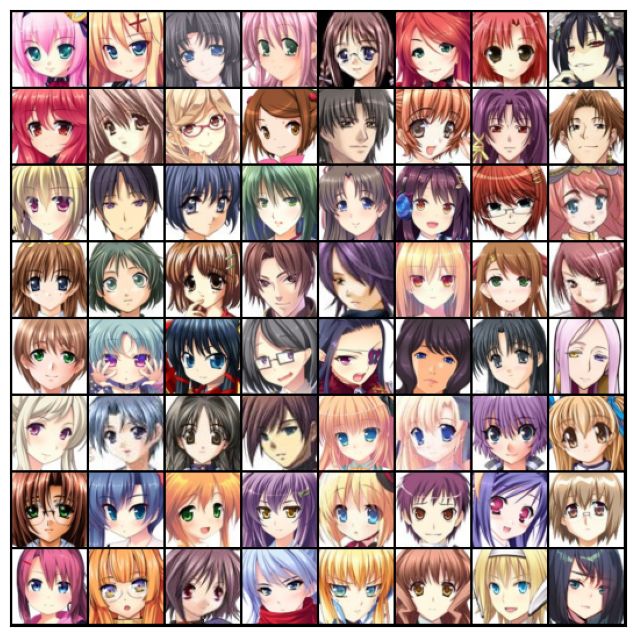

In [12]:
show_batch(train_dl);

## Using GPU

In [13]:
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')


def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [14]:
device=get_device()

In [15]:
class DeviceDataLoader():

  def __init__(self, dl, device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)


In [16]:
train_dl = DeviceDataLoader(train_dl, device)

# Discriminator Model

In [17]:
import torch.nn as nn

In [18]:
discriminator = nn.Sequential(

                              #input: b_size x 3 x 64 x 64



                              nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias = False),
                              nn.BatchNorm2d(64),
                              nn.LeakyReLU(0.2, inplace = True),
                              #out: b_size x 64 x 32 x 32



                              nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias = False),
                              nn.BatchNorm2d(128),
                              nn.LeakyReLU(0.2,  inplace= True),
                              #out: b_size x 128 x 16 x 16



                              nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias = False),
                              nn.BatchNorm2d(256),
                              nn.LeakyReLU(0.2,  inplace= True),
                              #out: b_size x 256 x 8 x 8


                              nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias = False),
                              nn.BatchNorm2d(512),
                              nn.LeakyReLU(0.2,  inplace= True),
                              #out: b_size x 512 x 4 x 4


                              nn.Conv2d( 512, 1, kernel_size=4, stride=2, padding=0, bias = False),


                              #out: b_size x 1 x 1 x 1

                              nn.Flatten(),
                              nn.Sigmoid()

                              )

In [19]:
device = get_device()
print(device)
discriminator = to_device(discriminator, device)

cuda


# Generator

In [20]:
latent_size = 128

In [21]:
generator=nn.Sequential(

    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size = 4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #out: 128 x 18 x 18

    nn.ConvTranspose2d(128,64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #out: 64 x 32 x 32

    nn.ConvTranspose2d(64,3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    #out 3 x 64 x 64
)


xb  torch.Size([64, 128, 1, 1])
torch.Size([64, 3, 64, 64])


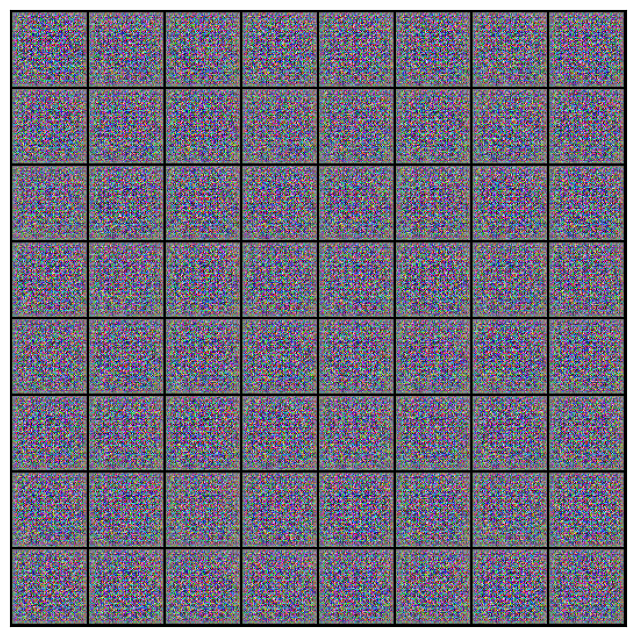

In [22]:
#Testing generators

xb=torch.rand(batch_size, latent_size, 1, 1)
fake_image = generator(xb)
print("xb ", xb.shape)
print(fake_image.shape)
show_image(fake_image)

In [23]:
#generator to device
generator=to_device(generator, device)

In [24]:
gen=generator(torch.rand(batch_size, latent_size, 1, 1, device=device))
print(gen.shape)
gen=discriminator(gen)
print(gen.shape)

torch.Size([64, 3, 64, 64])
torch.Size([64, 1])


# Train discriminator

In [25]:
import torch.nn.functional as F

In [26]:
def train_discriminator(real_images, opt_d):

  opt_d.zero_grad()
  #pass real image through discriminators
  real_pred=discriminator(real_images)
  real_target=torch.ones(real_images.size(0), 1, device=device)

  real_loss = F.binary_cross_entropy(real_pred, real_target)

  real_score=torch.mean(real_pred).item()



  #Generate Fake images
  latent=torch.rand(batch_size, latent_size, 1, 1, device=device)
  fake_image=generator(latent)


  #pass fake images through discrimnator
  fake_target=torch.zeros(fake_image.size(0), 1, device=device)
  fake_pred= discriminator(fake_image)
  fake_loss=F.binary_cross_entropy(fake_pred, fake_target)
  fake_score= torch.mean(fake_pred).item()



  #update Discriminator weight:
  loss=real_loss+fake_loss
  loss.backward(retain_graph=True)
  opt_d.step()


  return loss.item() , real_score, fake_score

# Train Generator

In [27]:
def train_generator(opt_g):
  opt_g.zero_grad()

  #Generate fake images
  latent=torch.rand(batch_size, latent_size, 1,1, device=device)
  Fake_image=generator(latent)


  # Trying to fool Discriminator
  preds=discriminator(fake_image)
  target=torch.ones(batch_size, 1, device=device)

  loss=F.binary_cross_entropy(preds, target)


  loss.backward(retain_graph=True)
  opt_g.step()
  return loss.item()

In [28]:
def train_generator(opt_g):
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.rand(batch_size, latent_size, 1, 1, device=device)
    fake_image = generator(latent)

    # Trying to fool Discriminator
    preds = discriminator(fake_image)
    target = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, target)

    # Detach fake_image to prevent in-place modification issues
    loss.backward(retain_graph=True)
    opt_g.step()

    return loss.item()


In [29]:
from torchvision.utils import save_image

In [30]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [31]:
def save_samples(index, latent_tensor, show= True):

  fake_image=generator(latent_tensor)
  fake_fname='generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_image), os.path.join(sample_dir,fake_fname), nrow=8)

  print('Saving...', fake_fname)

  if show:
    fig, ax=plt.subplots(figsize = (8, 8))

    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_image.cpu().detach(), nrow=8).permute(1,2,0))

In [32]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [33]:
save_samples(0, fixed_latent, show=False)

Saving... generated-images-0000.png


In [34]:
from tqdm.notebook import tqdm

# Training the model

In [35]:
def fit(epochs, lr, start_idx=1):
    torch.autograd.set_detect_anomaly(True)
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):

        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)

            # Train generator

            loss_g = train_generator(opt_g)

        # Record losses & scores

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [36]:
lr=0.0002
epoches=5

In [ ]:
%%time
history=fit(epoches, lr)

  0%|          | 0/994 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 6.7385, loss_d: 0.0372, real_score: 0.9665, fake_score: 0.0020
Saving... generated-images-0001.png


  0%|          | 0/994 [00:00<?, ?it/s]